# Demonstrate the Aggregated Prediction Methods

In [1]:
import helper
import aggregated_predict as ap
import pandas as pd
import joblib
import time
import warnings
warnings.simplefilter('ignore')

## 1. Testing of each model and demonstration of model aggregated prediction methods

Sensor Model 1 Prediction Results:
-----------------------------
Accuracy : 0.9344786060114527
Precision: 0.9345316212741565
Recall   : 0.9344786060114527
F1 Score : 0.9345024049100862
-----------------------------

Sensor Model 2 Prediction Results:
-----------------------------
Accuracy : 0.9354862493548625
Precision: 0.9355767676548765
Recall   : 0.9354862493548625
F1 Score : 0.9355242882912186
-----------------------------

Sensor Model 3 Prediction Results:
-----------------------------
Accuracy : 0.9337904593379046
Precision: 0.9338128372470669
Recall   : 0.9337904593379046
F1 Score : 0.9338011211130184
-----------------------------

Network Model Prediction Results:
-----------------------------
Accuracy : 0.9978864066455307
Precision: 0.9978882211883582
Recall   : 0.9978864066455307
F1 Score : 0.9978867469991536
-----------------------------


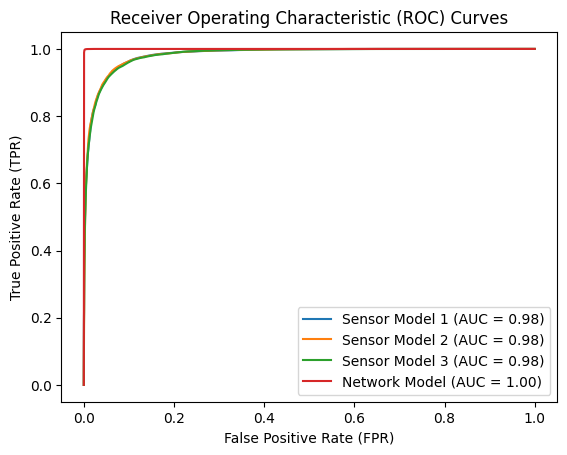

In [2]:
# Load the testing set
sensor_test, network_test = helper.load_test_set()

# Load the models
sensor_models = ['./received_models/client_1.joblib', './received_models/client_2.joblib', './received_models/client_3.joblib']
network_model = './received_models/global_model.joblib'

# Test models 
models_predictions, models_metrics = ap.get_predictions_and_metrics(
    local_models=sensor_models,
    sensor_test=sensor_test,
    global_model=network_model,
    network_test=network_test,
)

In [3]:
# Load network testing set, set the weights
y_test = network_test.iloc[:, -1]
model_weights = [0.2, 0.2, 0.2, 0.4]

In [4]:
print(f"Aggregated Prediction by Score:")
score = ap.aggregate_predict_by_score(
    models_predictions=models_predictions,
    models_metrics=models_metrics,
    models_weights=model_weights)
helper.get_metrics(y_test, score, printout=True)

Aggregated Prediction by Score:
-----------------------------
Accuracy : 0.986728599867286
Precision: 0.9867410175004202
Recall   : 0.986728599867286
F1 Score : 0.986732716754481
-----------------------------


(0.986728599867286, 0.9867410175004202, 0.986728599867286, 0.986732716754481)

In [5]:
print(f"Aggregated Prediction by Vote:")
vote = ap.aggregate_predict_by_vote(models_predictions=models_predictions)
helper.get_metrics(y_test, vote, printout=True)

Aggregated Prediction by Vote:
-----------------------------
Accuracy : 0.9712944530462778
Precision: 0.9732263690999153
Recall   : 0.9712944530462778
F1 Score : 0.9714481286358484
-----------------------------


(0.9712944530462778,
 0.9732263690999153,
 0.9712944530462778,
 0.9714481286358484)

## 2. Simulation of Intrusion Detection in Wireless Sensor Networks

Once the WSN simulation starts, the sensors in the nodes will collect new sensing data, these data need to pass the validation of the local models first. The data that passes the validation will be sent to the server and the data that does not pass will be discarded. Once the server receives the sensed data, it will validate the sensor data and the network traffic generated by the transmitted data by aggregated prediction method to give the final validation result. If the data passes the validation, the data is saved, otherwise, the data is discarded.

In [6]:
sensor_test['target'].value_counts()

target
0    24609
1    16080
Name: count, dtype: int64

In [7]:
# Select 10000 equally distributed samples from the testing set
s0 = sensor_test[sensor_test['target'] == 0].sample(10000)
s1 = sensor_test[sensor_test['target'] == 1].sample(10000)
sampled_sensor_data = pd.concat([s0, s1])
sampled_network_data = network_test.loc[sampled_sensor_data.index]

sampled_sensor_data = sampled_sensor_data.reset_index(drop=True)
sampled_network_data = sampled_network_data.reset_index(drop=True)

print(sampled_sensor_data['target'].value_counts())
print(sampled_network_data['target'].value_counts())

target
0    10000
1    10000
Name: count, dtype: int64
target
0    10000
1    10000
Name: count, dtype: int64


In [8]:
# Use Client 1 as an example
client_1_model = joblib.load('./received_models/client_1.joblib')
test_X = sampled_sensor_data.iloc[:, :-1]
test_y = sampled_sensor_data.iloc[:, -1]
client_1_predict = client_1_model.predict(test_X)
helper.get_metrics(test_y, client_1_predict, printout=True)

-----------------------------
Accuracy : 0.93205
Precision: 0.9323445174087039
Recall   : 0.93205
F1 Score : 0.9320384259740394
-----------------------------


(0.93205, 0.9323445174087039, 0.93205, 0.9320384259740394)

In [9]:
client_1_predict_df = pd.DataFrame(client_1_predict, columns=['Pred'])
client_1_predict_df['Pred'].value_counts()

Pred
0    10261
1     9739
Name: count, dtype: int64

In [10]:
# Client 1 will test the sensor data locally, only those that pass will be sent to the server
# Drop false data, target = 1
rows_to_keep = client_1_predict_df['Pred'] == 0
filtered_sensor_data = sampled_sensor_data[rows_to_keep]
filtered_network_data = sampled_network_data[rows_to_keep]

print(filtered_sensor_data['target'].value_counts())
print(filtered_network_data['target'].value_counts())

target
0    9451
1     810
Name: count, dtype: int64
target
0    9451
1     810
Name: count, dtype: int64


Sensor Model 1 Prediction Results:
-----------------------------
Accuracy : 0.9210603255043368
Precision: 0.8483521232181549
Recall   : 0.9210603255043368
F1 Score : 0.8832123717878945
-----------------------------

Sensor Model 2 Prediction Results:
-----------------------------
Accuracy : 0.9398694084397232
Precision: 0.9403137823508423
Recall   : 0.9398694084397232
F1 Score : 0.9400880606207933
-----------------------------

Sensor Model 3 Prediction Results:
-----------------------------
Accuracy : 0.9420134489815808
Precision: 0.9436648559817861
Recall   : 0.9420134489815808
F1 Score : 0.9427893044442893
-----------------------------

Network Model Prediction Results:
-----------------------------
Accuracy : 0.9977585030698762
Precision: 0.9978050164639342
Recall   : 0.9977585030698762
F1 Score : 0.997770367580271
-----------------------------


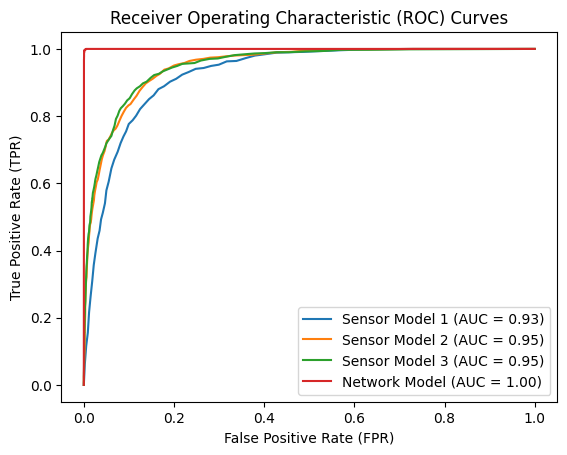

In [11]:
# Test Client 1 data using all models
new_models_predictions, new_models_metrics = ap.get_predictions_and_metrics(
    local_models=sensor_models,
    sensor_test=filtered_sensor_data,
    global_model=network_model,
    network_test=filtered_network_data,
)

In [12]:
# Load Client 1 network testing set, set the weights
new_y_test = filtered_network_data.iloc[:, -1]
new_model_weights = [0.4, 0.05, 0.05, 0.5]

In [13]:
print(f"Client 1 Aggregated Prediction by Score:")
start_time = time.time()

new_score = ap.aggregate_predict_by_score(
    models_predictions=new_models_predictions,
    models_metrics=new_models_metrics,
    models_weights=new_model_weights)

end_time = time.time()
rows = len(new_models_predictions[0])
time_spend = end_time - start_time

helper.get_metrics(new_y_test, new_score, printout=True)
print(f"Time spent predicting {rows} pieces of data: {time_spend} second, average time spent: {time_spend / rows} seconds.")

Client 1 Aggregated Prediction by Score:
-----------------------------
Accuracy : 0.9977585030698762
Precision: 0.9978050164639342
Recall   : 0.9977585030698762
F1 Score : 0.997770367580271
-----------------------------


Time spent predicting 10261 pieces of data: 0.0009996891021728516 second, average time spent: 9.742608928689715e-08 seconds.


In [14]:
print(f"Client 1 Aggregated Prediction by Vote:")
start_time = time.time()

new_vote = ap.aggregate_predict_by_vote(models_predictions=new_models_predictions)

end_time = time.time()
time_spend = end_time - start_time

helper.get_metrics(new_y_test, new_vote, printout=True)
print(f"Time spent predicting {rows} pieces of data: {time_spend} second, average time spent: {time_spend / rows} seconds.")

Client 1 Aggregated Prediction by Vote:
-----------------------------
Accuracy : 0.9876230386901862
Precision: 0.9892633774873519
Recall   : 0.9876230386901862
F1 Score : 0.9880251423829866
-----------------------------


Time spent predicting 10261 pieces of data: 0.0060002803802490234 second, average time spent: 5.847656544439161e-07 seconds.
